<a href="https://www.kaggle.com/code/jiwonkng/tabular-playground-apr-22?scriptVersionId=93648368" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


# Step 1. Library and Dataset

## Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import *
import seaborn as sns
from scipy.stats import kde, kurtosis
from scipy.stats.mstats import gmean


import os

print("Numpy ver.", np.__version__)
print("Pandas ver.", pd.__version__)
print("Matplotlib ver.", matplotlib.__version__)
print("Seaborn ver.", sns.__version__)

print(os.listdir('../input/tabular-playground-series-apr-2022'))

Numpy ver. 1.20.3
Pandas ver. 1.3.5
Matplotlib ver. 3.5.1
Seaborn ver. 0.11.2
['sample_submission.csv', 'train_labels.csv', 'train.csv', 'test.csv']


In [3]:
# !pip install pycaret==2.2.3

In [4]:
# from pycaret.utils import version
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
import time
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [5]:
BASE_DIR = '../input/tabular-playground-series-apr-2022/'
train = pd.read_csv(BASE_DIR + "train.csv")
train_labels = pd.read_csv(BASE_DIR + "train_labels.csv")
test = pd.read_csv(BASE_DIR + "test.csv")
submission = pd.read_csv(BASE_DIR + "sample_submission.csv")
print("Train Data:",train.shape)
print("Train Label Data:",train_labels.shape)
print("Test Data:",test.shape)
print("Sample Data:",submission.shape)

Train Data: (1558080, 16)
Train Label Data: (25968, 2)
Test Data: (733080, 16)
Sample Data: (12218, 2)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


In [7]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25968 entries, 0 to 25967
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sequence  25968 non-null  int64
 1   state     25968 non-null  int64
dtypes: int64(2)
memory usage: 405.9 KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733080 entries, 0 to 733079
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sequence   733080 non-null  int64  
 1   subject    733080 non-null  int64  
 2   step       733080 non-null  int64  
 3   sensor_00  733080 non-null  float64
 4   sensor_01  733080 non-null  float64
 5   sensor_02  733080 non-null  float64
 6   sensor_03  733080 non-null  float64
 7   sensor_04  733080 non-null  float64
 8   sensor_05  733080 non-null  float64
 9   sensor_06  733080 non-null  float64
 10  sensor_07  733080 non-null  float64
 11  sensor_08  733080 non-null  float64
 12  sensor_09  733080 non-null  float64
 13  sensor_10  733080 non-null  float64
 14  sensor_11  733080 non-null  float64
 15  sensor_12  733080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 89.5 MB


In [9]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12218 entries, 0 to 12217
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sequence  12218 non-null  int64
 1   state     12218 non-null  int64
dtypes: int64(2)
memory usage: 191.0 KB


In [10]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [11]:
train_labels.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [12]:
test.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


In [13]:
submission.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [14]:
# train = train.set_index(['sequence', 'subject', 'step'])
# test = test.set_index(['sequence', 'subject', 'step'])

# Step 2. EDA

## Overview of data

In [15]:
df = train.describe()
display(df.style.format('{:,.2f}')\
        .background_gradient(subset=(df.index[3:], df.columns[3:]),
                             cmap="RdBu", vmin=-700, vmax=700, axis=1))

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
count,"1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00"
mean,"12,983.50",331.63,29.50,0.00,-0.00,-0.22,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.01
std,"7,496.32",195.83,17.32,2.66,4.40,2.30,3.93,1.68,1.59,3.35,3.24,4.50,2.59,1.92,4.53,39.12
min,0.00,0.00,0.00,-375.06,-434.60,-31.66,-408.38,-23.63,-74.98,-470.50,-407.01,-536.10,-270.35,-43.41,-427.06,-612.55
25%,"6,491.75",161.75,14.75,-0.50,-0.48,-0.65,-0.49,-0.47,-0.48,-0.49,-0.50,-0.50,-0.52,-0.48,-0.48,-0.58
50%,"12,983.50",335.00,29.50,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00
75%,"19,475.25",501.00,44.25,0.48,0.49,0.33,0.49,0.47,0.51,0.49,0.48,0.50,0.51,0.48,0.49,0.57
max,"25,967.00",671.00,59.00,335.82,449.59,1.67,436.65,24.87,77.92,442.50,331.25,630.10,367.98,41.87,448.02,630.51


In [16]:
df2 = test.describe()
display(df2.style.format('{:,.2f}')\
        .background_gradient(subset=(df2.index[3:], df2.columns[3:]),
                             cmap="RdBu", vmin=-700, vmax=700, axis=1))

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
count,"733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00","733,080.00"
mean,"32,076.50",829.36,29.50,0.00,-0.00,-0.22,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
std,"3,527.04",92.61,17.32,2.93,4.60,2.34,4.88,1.88,1.63,3.42,2.77,4.99,2.80,2.11,4.40,40.82
min,"25,968.00",672.00,0.00,-347.38,-457.26,-31.66,-425.28,-24.75,-55.14,-435.77,-299.24,-544.90,-312.63,-43.73,-443.71,-572.73
25%,"29,022.00",750.00,14.75,-0.50,-0.48,-0.58,-0.49,-0.52,-0.51,-0.49,-0.49,-0.50,-0.52,-0.49,-0.48,-0.87
50%,"32,076.50",833.00,29.50,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00
75%,"35,131.00",909.00,44.25,0.48,0.49,0.33,0.48,0.52,0.53,0.49,0.48,0.50,0.51,0.49,0.49,0.87
max,"38,185.00",990.00,59.00,403.79,551.54,1.67,498.47,24.54,62.82,484.38,324.04,769.60,306.49,39.19,375.81,536.12


In [17]:
missing = pd.DataFrame({
    'train_miss' : train.isna().sum(),
    'test_miss' : test.isna().sum(),
})
print("Missing Value :")
missing.T

Missing Value :


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
train_miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
test_miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- train 데이터와 test 데이터 모두 결측치는 존재하지 않는다.
- 13가지의 sensor 변수는 대부분이 -1에서 1 사이의 값을 가지지만, 그에 벗어나는 이상치가 존재한다.

## Target Distribution

In [18]:
train = train.merge(train_labels, on='sequence')
train['state'].value_counts()

1    780840
0    777240
Name: state, dtype: int64

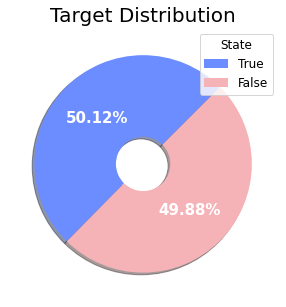

In [19]:
train_0 = train[train['state']==0]
train_1 = train[train['state']==1]

fig, ax = plt.subplots(figsize=(5,5))
labels = list(map(bool, train['state'].value_counts().index))
lst = train['state'].value_counts().to_list()

pie = ax.pie(lst, labels=labels, autopct='%.2f%%',
             textprops=dict(color="white", fontsize=15, weight="bold"),
             colors = ['#6B8DFF', '#F5B3B8'], shadow=True,
             wedgeprops=dict(width=0.75), startangle=45)
ax.set_title("Target Distribution", size=20)
ax.legend(title="State", title_fontsize=12, loc="best", fontsize=12)

plt.show()

## Sequence, Subject, Step

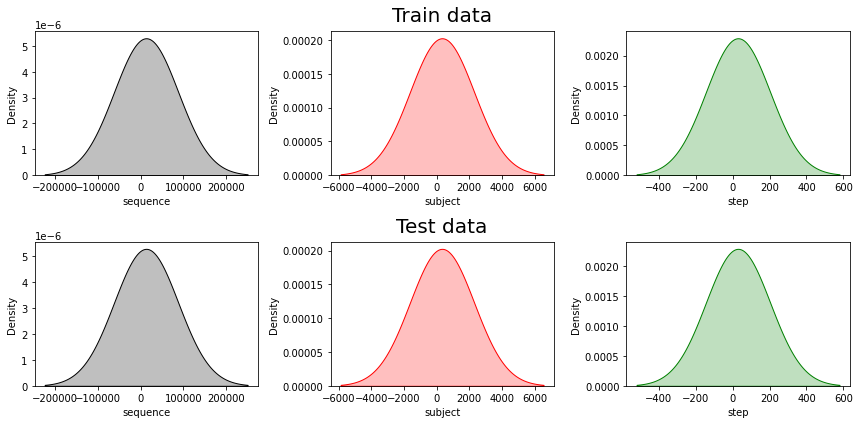

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(12, 3*2))

sns.kdeplot(data=train, x='sequence', shade=True, bw=10, color='black',ax=axes[0][0])
sns.kdeplot(data=train, x='subject', shade=True, bw=10, color='red', ax=axes[0][1])
sns.kdeplot(data=train, x='step', shade=True, bw=10, color='green', ax=axes[0][2])

sns.kdeplot(data=train, x='sequence', shade=True, bw=10, color='black',ax=axes[1][0])
sns.kdeplot(data=train, x='subject', shade=True, bw=10, color='red', ax=axes[1][1])
sns.kdeplot(data=train, x='step', shade=True, bw=10, color='green', ax=axes[1][2])

axes[0][1].set_title("Train data", pad = 10, size=20)
axes[1][1].set_title("Test data", pad = 10, size=20)

plt.tight_layout()
plt.show()

- train 데이터와 test 데이터 모두 sequence, subject, step은 정규분포의 형태를 보인다.

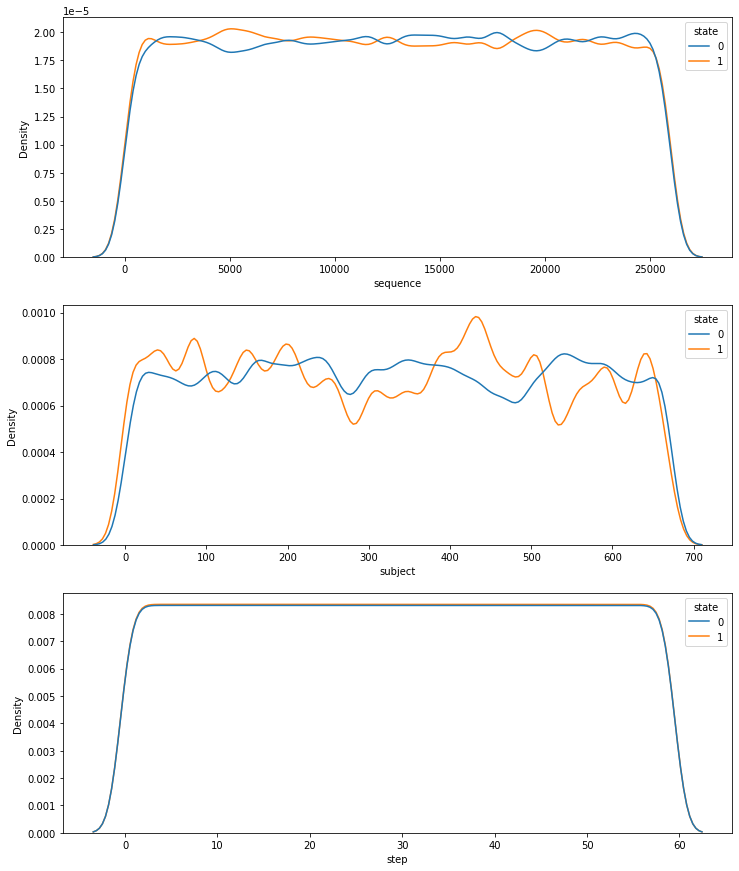

In [21]:
fig, axes = plt.subplots(3,1,figsize=(12,5*3))

sns.kdeplot(data=train,x='sequence', hue='state', ax=axes[0])
sns.kdeplot(data=train,x='subject', hue='state', ax=axes[1])
sns.kdeplot(data=train,x='step', hue='state', ax=axes[2])

plt.show()

- train 데이터에서 sequence는 state의 값에 따른 분포의 차이가 크지 않지만, <br/>subject는 다소 상이한 분포를 보이며, step은 state의 값과 상관 없이 균일한 분포를 보인다.

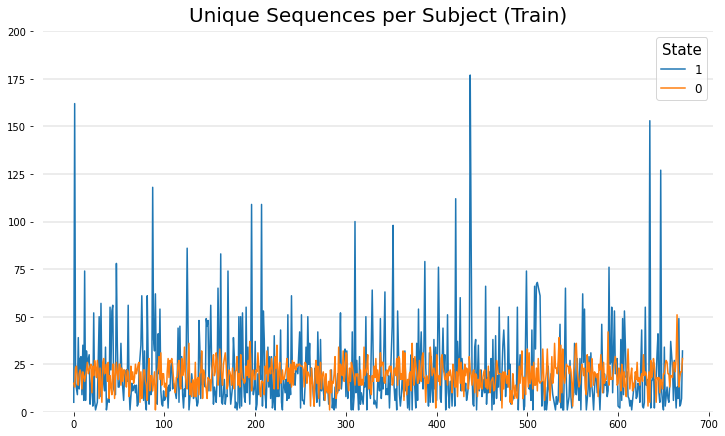

In [22]:
ss = train.groupby(['subject', 'state'])['sequence'].nunique().reset_index()
fig, ax = plt.subplots(figsize=(12,7))

for i in reversed(range(0,2)):
    x = ss[ss['state']==i]['subject']
    y = ss[ss['state']==i]['sequence']
    ax.plot(x,y)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(("outward", 10))
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(0,200)
ax.set_title("Unique Sequences per Subject (Train)", pad = 10, size=20)
ax.legend([1, 0], title="State", title_fontsize=15,
          loc="upper right", fontsize=12)
ax.grid(axis="y", linewidth=0.3, color="gray")
plt.show()

- 각 subject에 대한 고유 sequence의 수는 State 값이 1인 경우에 대체로 큰 값을 보이며, State 값이 0인 경우에는 50 이내에서 비교적 고른 분포를 보인다.

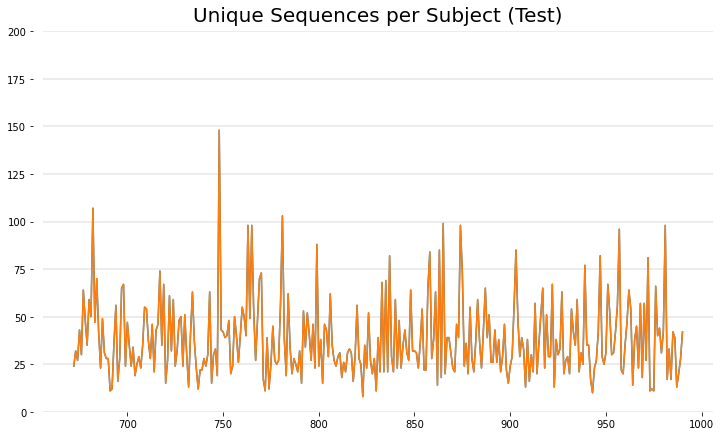

In [23]:
ss = test.groupby(['subject'])['sequence'].nunique().reset_index()
fig, ax = plt.subplots(figsize=(12,7))

for i in reversed(range(0,2)):
    x = ss['subject']
    y = ss['sequence']
    ax.plot(x,y)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(("outward", 10))
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(0,200)
ax.set_title("Unique Sequences per Subject (Test)", pad = 10, size=20)
ax.grid(axis="y", linewidth=0.3, color="gray")
plt.show()

- 같은 맥락으로, Test 데이터에서도 subject에 대한 고유 sequence의 수가 State 값에 영향을 미칠 것으로 보인다.

## Sensors Ditributions

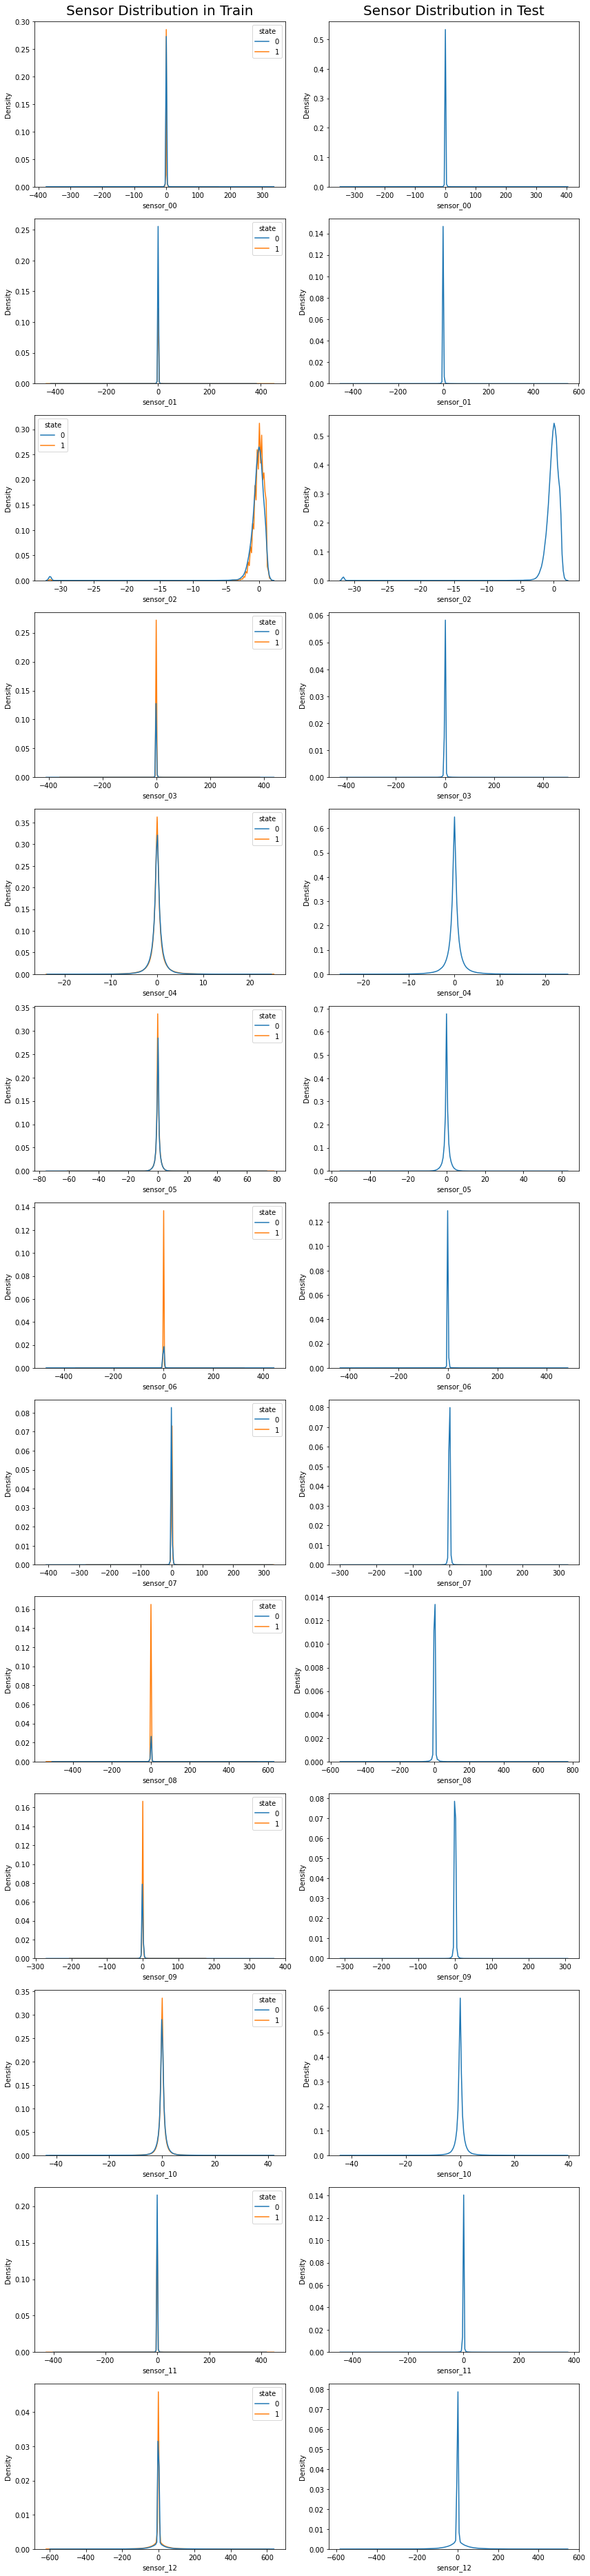

In [24]:
sensors = [col for col in train if col.startswith('sensor')]

fig, axes = plt.subplots(13, 2, figsize=(12, 13*4))

row = 0
for sensor in sensors:
    sns.kdeplot(data=train, x=sensor, hue='state', ax=axes[row][0])
    sns.kdeplot(data=test, x=sensor, ax=axes[row][1])
    row += 1

axes[0][0].set_title("Sensor Distribution in Train", pad = 10, size = 20)
axes[0][1].set_title("Sensor Distribution in Test", pad = 10, size = 20)
    
fig.tight_layout()
plt.show()

- 대부분의 sensor는 0을 기준으로 좌우 대칭의 형태를 띄고 있으나, sensor_02의 경우 왼쪽 꼬리가 긴 분포를 보인다.
- 각 sensor마다 이상치로 인해 전체적인 분포가 잘 드러나지 않기 때문에 적절한 이상치 처리가 필요하다.

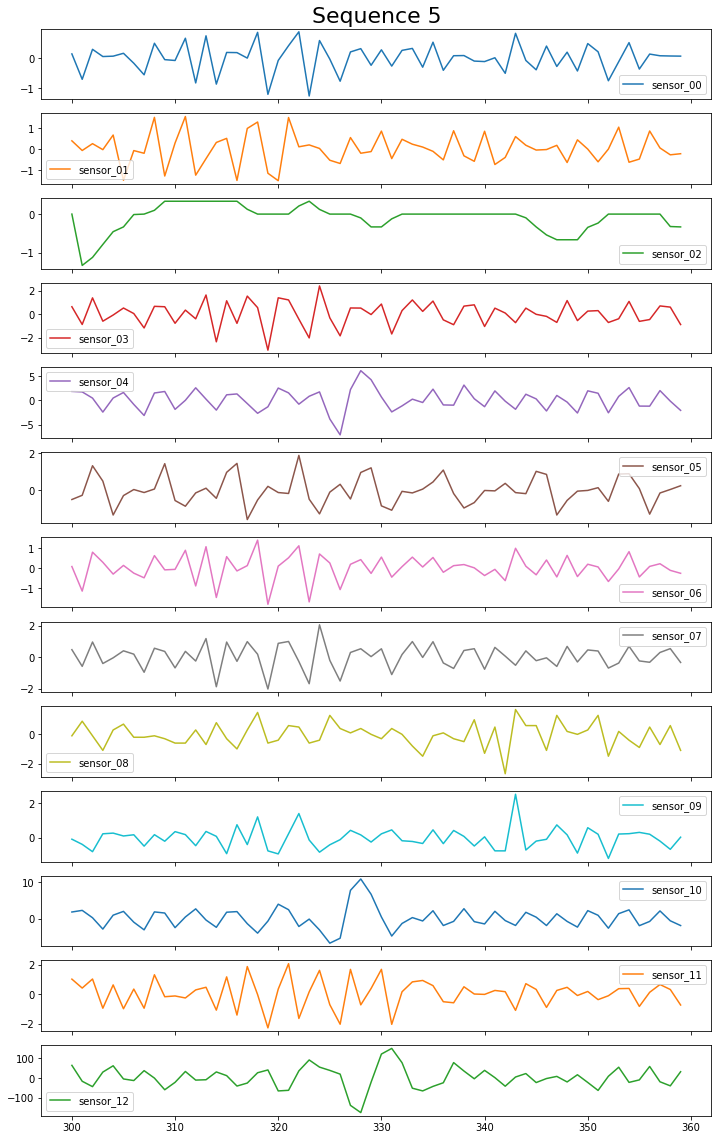

In [25]:
def plot_sequence(sequence: int) -> None:
    mask = train.sequence == sequence
    ax = train[mask][sensors].plot(subplots=True,
                                   sharex=True,
                                   figsize=(12,20))
    ax[0].set_title(f'Sequence {sequence}', size=22)
    plt.show()

plot_sequence(5)

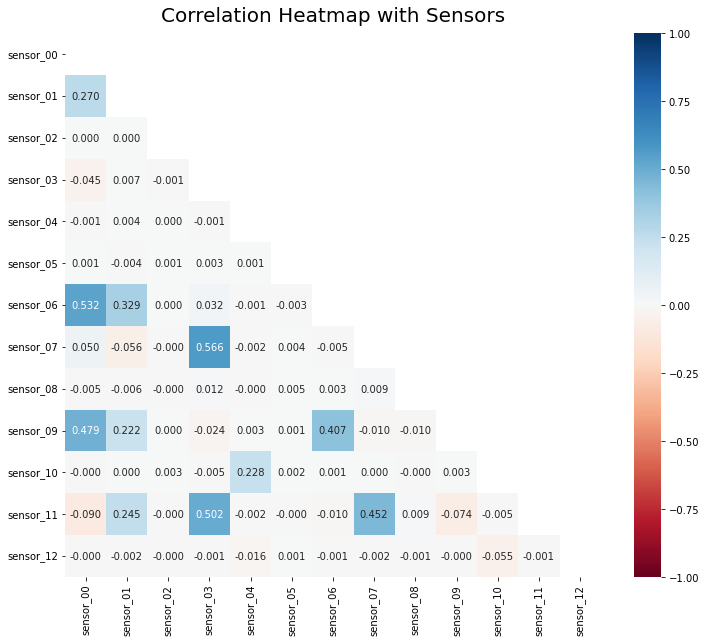

In [26]:
fig, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(train[sensors].corr(), dtype=np.bool))
sns.heatmap(train[sensors].corr(), mask = mask,
            cmap = "RdBu", vmin = -1, vmax = 1, annot = True, fmt = '.3f')
ax.set_title('Correlation Heatmap with Sensors', pad = 12, size=20)

plt.show()

- 대부분의 sensor들 사이에는 상관관계가 약하거나 거의 없는 것으로 나타나지만, <br/>
  (sensor_00, sensor_06, sensor_09), (sensor_03, sensor_07, sensor_11)은 비교적 강한 상관관계를 가지는 변수 집합이다.
- 따라서 상관계수가 가장 큰 sensor_00과 sensor_03만 선택하고 sensor_06, sensor_07, sensor_09, sensor_11은 제거할 수 있다.

# Step 3. Data Preprocessing

## Outlier Processing
- Sensor 데이터의 이상치를 IQR 방식으로 처리한다.
    - 하한값 : 1분위수 - IQR * 1.5
    - 상한값 : 3분위수 + IQR * 1.5
    - 하한값보다 작거나 상한값보다 큰 값은 평균값(0)으로 대체한다.

In [27]:
def get_outlier(df, col, weight=1.5):
    q1 = np.percentile(df[col].values, 25)
    q3 = np.percentile(df[col].values, 75)

    iqr = q3 - q1
    low_lim = q1 - iqr * weight
    high_lim = q3 + iqr * weight
    
    idx = df[col][(df[col] < low_lim) | (df[col] > high_lim)].index.tolist()
    df[col][idx] = 0
    return df

for sensor in sensors:
    get_outlier(train, sensor)
    get_outlier(test, sensor)

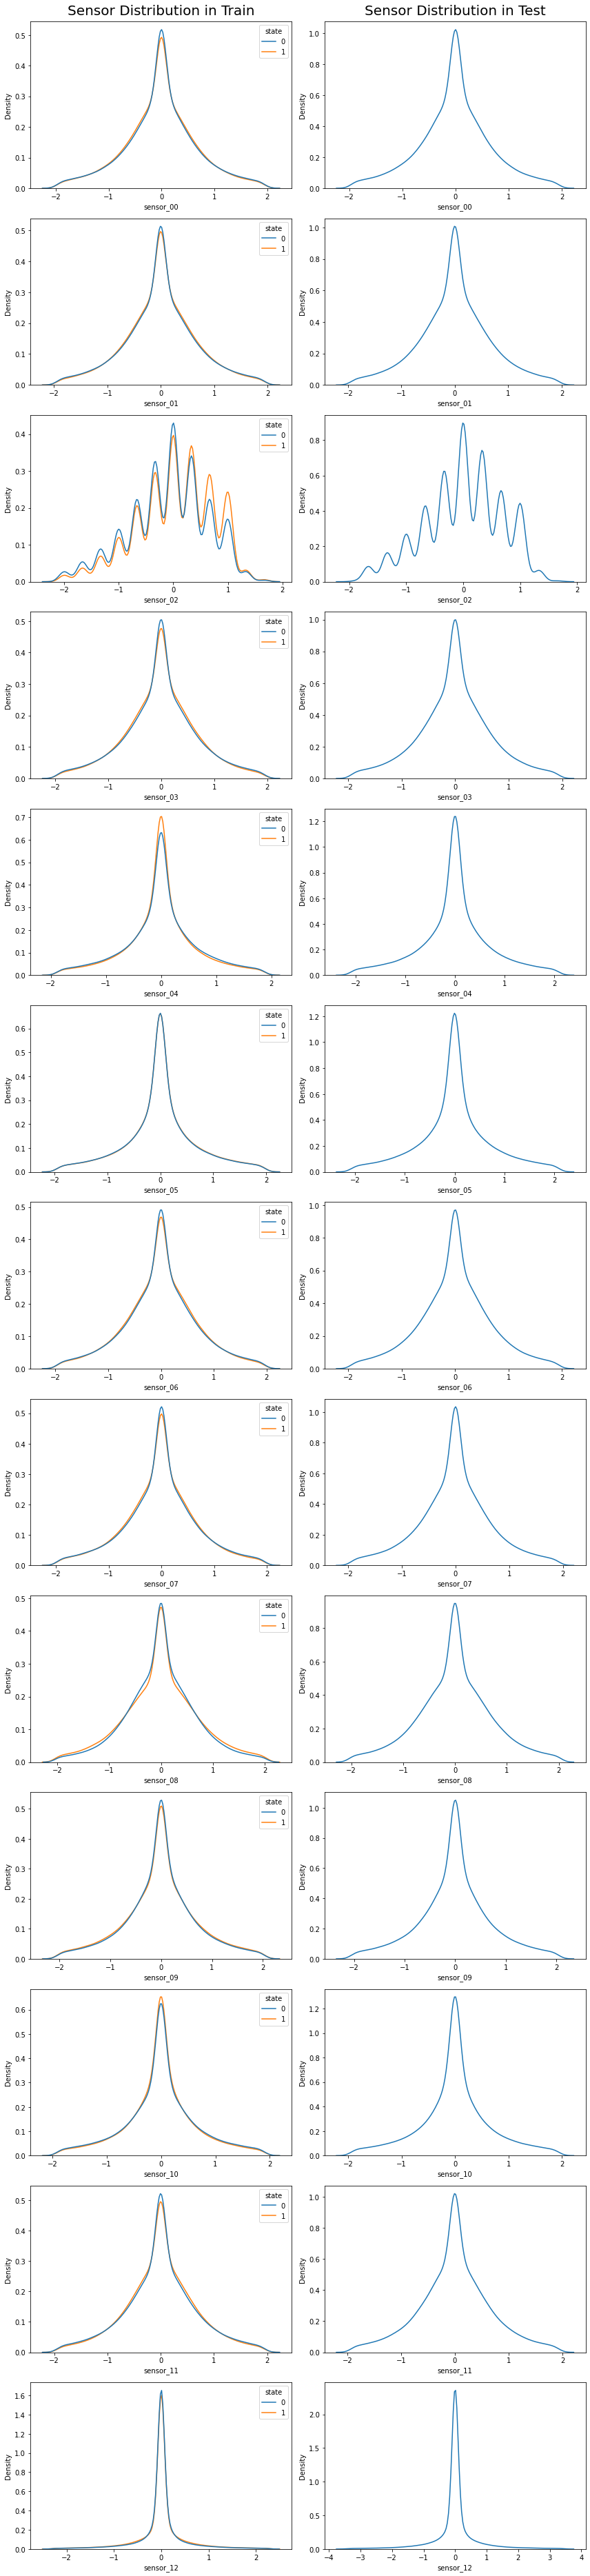

In [28]:
fig, axes = plt.subplots(13, 2, figsize=(12, 13*4))

row = 0
for sensor in sensors:
    sns.kdeplot(data=train, x=sensor, hue='state', bw_adjust=2, ax=axes[row][0])
    sns.kdeplot(data=test, x=sensor, bw_adjust=2, ax=axes[row][1])
    row += 1

axes[0][0].set_title("Sensor Distribution in Train", pad = 10, size = 20)
axes[0][1].set_title("Sensor Distribution in Test", pad = 10, size = 20)
    
fig.tight_layout()
plt.show()

- IQR 방식을 활용한 이상치 대체 후의 sensor 데이터를 보면,<br/>
  sensor_02를 제외한 모든 변수들이 0을 기준으로 좌우 대칭의 종 모양의 분포이지만 그 첨도는 상이하다.

## Feature Engineering

### Aggregated variables for sensors

In [29]:
for sensor in sensors:
    train[f'{sensor}_step_diff'] = train.groupby(['sequence','subject'])[sensor].diff()
    train[f'{sensor}_step_diff'].fillna(train[f'{sensor}_step_diff'].median(), inplace=True)
    train[f'{sensor}_step_mean'] = train.groupby(['sequence','subject'])[sensor].transform('mean')
    train[f'{sensor}_step_median'] = train.groupby(['sequence','subject'])[sensor].transform('median')
    train[f'{sensor}_step_std'] = train.groupby(['sequence','subject'])[sensor].transform('std')
    train[f'{sensor}_step_min'] = train.groupby(['sequence','subject'])[sensor].transform('min')
    train[f'{sensor}_step_max'] = train.groupby(['sequence','subject'])[sensor].transform('max')
    # train[f'{sensor}_kurtosis'] = train.groupby(['sequence','subject'])[sensor].apply(pd.DataFrame.kurt)
    
    test[f'{sensor}_step_diff'] = test.groupby(['sequence','subject'])[sensor].diff()
    test[f'{sensor}_step_diff'].fillna(test[f'{sensor}_step_diff'].median(), inplace=True)
    test[f'{sensor}_step_mean'] = test.groupby(['sequence','subject'])[sensor].transform('mean')
    test[f'{sensor}_step_median'] = test.groupby(['sequence','subject'])[sensor].transform('median')
    test[f'{sensor}_step_std'] = test.groupby(['sequence','subject'])[sensor].transform('std')
    test[f'{sensor}_step_min'] = test.groupby(['sequence','subject'])[sensor].transform('min')
    test[f'{sensor}_step_max'] = test.groupby(['sequence','subject'])[sensor].transform('max')
    # test[f'{sensor}_kurtosis'] = test.groupby(['sequence','subject'])[sensor].apply(pd.DataFrame.kurt)

### Sensor 2 : Is a constant

In [30]:
'''df = train.groupby(['sequence', 'step'])['sensor_02'].sum()
constant_s02 = df.unstack(-1).std(axis=1)[df.unstack(-1).std(axis=1) == 0]
isin_ = train['sequence'].isin(constant_s02.index.to_list())'''

"df = train.groupby(['sequence', 'step'])['sensor_02'].sum()\nconstant_s02 = df.unstack(-1).std(axis=1)[df.unstack(-1).std(axis=1) == 0]\nisin_ = train['sequence'].isin(constant_s02.index.to_list())"

In [31]:
'''train['Constant_s02'] = np.zeros(len(train))
train['Constant_s02'][isin_] = 1
train['Constant_s02'].value_counts()'''

"train['Constant_s02'] = np.zeros(len(train))\ntrain['Constant_s02'][isin_] = 1\ntrain['Constant_s02'].value_counts()"

In [32]:
# train[['Constant_s02', 'state']].value_counts()

# Step 4. Modeling

## Data Split

In [33]:
y = train['state'].copy()
X = train.drop('state', axis=1).copy()
X_test = test.copy()

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)
print("Train data\t:", X_train.shape, y_train.shape)
print("Validation data\t:", X_val.shape, y_val.shape)

Train data	: (1090656, 94) (1090656,)
Validation data	: (467424, 94) (467424,)


## Pycaret

In [35]:
'''from pycaret.classification import *
setup_clf = setup(data=train, target='state')'''

"from pycaret.classification import *\nsetup_clf = setup(data=train, target='state')"

In [36]:
'''best_model = compare_models(sort='AUC', fold=5,
                            include=['rf', 'knn', 'lr', 'svm', 'lightgbm'])'''

"best_model = compare_models(sort='AUC', fold=5,\n                            include=['rf', 'knn', 'lr', 'svm', 'lightgbm'])"

In [37]:
'''pred = predict_model(best_model, data=test)
pred.head()'''

'pred = predict_model(best_model, data=test)\npred.head()'

## Hyperparameter Tuning

### Grid Search

In [38]:
'''# define classifier
classifiers = {
    "KNN" : KNeighborsClassifier(),
    "LogisticRegression" : LogisticRegression(random_state=42),
    "RandomForest" : RandomForestClassifier(random_state=42),
    "LGBM" : LGBMClassifier(random_state=42),
    "SVM" : SVC(random_state=42)
}

# define grid
KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25],
           'max_iter': [50, 100, 150]}

RF_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [6, 8, 10, 12]}

LGBM_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [6, 8, 10, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

SVM_grid = [{'svc__C': [0.01, 0.1, 1.0, 10.0],
             'svc__kernel': ['linear']},
            {'svc__C': [0.01, 0.1, 1.0, 10.0],
             'svc__gamma': [0.01, 0.1, 1.0, 10.0],
             'svc__kernel': ['rbf']}]

grid = {
    "KNN" : KNN_grid,
    "LogisticRegression" : LR_grid,
    "RandomForest" : RF_grid,
    "LGBM" : LGBM_grid,
    "SVM" : SVM_grid
}'''

'# define classifier\nclassifiers = {\n    "KNN" : KNeighborsClassifier(),\n    "LogisticRegression" : LogisticRegression(random_state=42),\n    "RandomForest" : RandomForestClassifier(random_state=42),\n    "LGBM" : LGBMClassifier(random_state=42),\n    "SVM" : SVC(random_state=42)\n}\n\n# define grid\nKNN_grid = {\'n_neighbors\': [3, 5, 7, 9],\n            \'p\': [1, 2]}\n\nLR_grid = {\'penalty\': [\'l1\',\'l2\'],\n           \'C\': [0.25, 0.5, 0.75, 1, 1.25],\n           \'max_iter\': [50, 100, 150]}\n\nRF_grid = {\'n_estimators\': [50, 100, 150, 200],\n        \'max_depth\': [6, 8, 10, 12]}\n\nLGBM_grid = {\'n_estimators\': [50, 100, 150, 200],\n        \'max_depth\': [6, 8, 10, 12],\n        \'learning_rate\': [0.05, 0.1, 0.15]}\n\nSVM_grid = [{\'svc__C\': [0.01, 0.1, 1.0, 10.0],\n             \'svc__kernel\': [\'linear\']},\n            {\'svc__C\': [0.01, 0.1, 1.0, 10.0],\n             \'svc__gamma\': [0.01, 0.1, 1.0, 10.0],\n             \'svc__kernel\': [\'rbf\']}]\n\ngrid = {

In [39]:
'''i=0
clf_best_params = classifiers.copy()
scores = pd.DataFrame({
                    'Classifer':classifiers.keys(),
                    'Train accuracy' : np.zeros(len(classifiers)),
                    'Validation accuracy': np.zeros(len(classifiers)),
                    'Training time': np.zeros(len(classifiers))
                    })

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    clf.fit(X_train, y_train)
    scores.iloc[i,1]=clf.score(X_train, y_train)
    scores.iloc[i,2]=clf.score(X_val, y_val)
    clf_best_params[key]=clf.best_params_
    
    stop = time.time()
    scores.iloc[i,3]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', scores.iloc[i,3])
    print('')
    i+=1'''

"i=0\nclf_best_params = classifiers.copy()\nscores = pd.DataFrame({\n                    'Classifer':classifiers.keys(),\n                    'Train accuracy' : np.zeros(len(classifiers)),\n                    'Validation accuracy': np.zeros(len(classifiers)),\n                    'Training time': np.zeros(len(classifiers))\n                    })\n\nfor key, classifier in classifiers.items():\n    start = time.time()\n    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)\n\n    clf.fit(X_train, y_train)\n    scores.iloc[i,1]=clf.score(X_train, y_train)\n    scores.iloc[i,2]=clf.score(X_val, y_val)\n    clf_best_params[key]=clf.best_params_\n    \n    stop = time.time()\n    scores.iloc[i,3]=np.round((stop - start)/60, 2)\n    \n    print('Model:', key)\n    print('Training time (mins):', scores.iloc[i,3])\n    print('')\n    i+=1"

### Random Search

In [40]:
'''# define classifier
classifiers = {
    "KNN" : KNeighborsClassifier(),
    "LogisticRegression" : LogisticRegression(random_state=42),
    "RandomForest" : RandomForestClassifier(random_state=42),
    "LGBM" : LGBMClassifier(random_state=42),
    "SVM" : SVC(random_state=42)
}

# define grid
KNN_grid = {'n_neighbors': randint(3,9),
            'p': randint(1,2)}

LR_grid = {'penalty': ['l1','l2'],
           'C': uniform(0.25, 1.25),
           'max_iter': randint(50,150)}

RF_grid = {'n_estimators': randint(50,200),
        'max_depth': randint(4,12)}

LGBM_grid = {'n_estimators': randint(50,200),
        'max_depth': randint(4,12),
        'learning_rate': uniform(0.05, 0.15)}

SVM_grid = [{'svc__C': uniform(0.1, 10.0),
             'svc__kernel': ['linear']},
            {'svc__C': uniform(0.1, 10.0),
             'svc__gamma': uniform(0.1, 10.0),
             'svc__kernel': ['rbf']}]

grid = {
    "KNN" : KNN_grid,
    "LogisticRegression" : LR_grid,
    "RandomForest" : RF_grid,
    "LGBM" : LGBM_grid,
    "SVM" : SVM_grid
}'''

'# define classifier\nclassifiers = {\n    "KNN" : KNeighborsClassifier(),\n    "LogisticRegression" : LogisticRegression(random_state=42),\n    "RandomForest" : RandomForestClassifier(random_state=42),\n    "LGBM" : LGBMClassifier(random_state=42),\n    "SVM" : SVC(random_state=42)\n}\n\n# define grid\nKNN_grid = {\'n_neighbors\': randint(3,9),\n            \'p\': randint(1,2)}\n\nLR_grid = {\'penalty\': [\'l1\',\'l2\'],\n           \'C\': uniform(0.25, 1.25),\n           \'max_iter\': randint(50,150)}\n\nRF_grid = {\'n_estimators\': randint(50,200),\n        \'max_depth\': randint(4,12)}\n\nLGBM_grid = {\'n_estimators\': randint(50,200),\n        \'max_depth\': randint(4,12),\n        \'learning_rate\': uniform(0.05, 0.15)}\n\nSVM_grid = [{\'svc__C\': uniform(0.1, 10.0),\n             \'svc__kernel\': [\'linear\']},\n            {\'svc__C\': uniform(0.1, 10.0),\n             \'svc__gamma\': uniform(0.1, 10.0),\n             \'svc__kernel\': [\'rbf\']}]\n\ngrid = {\n    "KNN" : KNN_gr

In [41]:
'''i=0
clf_best_params = classifiers.copy()
scores = pd.DataFrame({
                    'Classifer':classifiers.keys(),
                    'Train accuracy' : np.zeros(len(classifiers)),
                    'Validation accuracy': np.zeros(len(classifiers)),
                    'Training time': np.zeros(len(classifiers))
                    })

for key, classifier in classifiers.items():
    start = time.time()
    clf = RandomizedSearchCV(estimator=classifier, param_distributions=grid[key], n_jobs=-1, n_iter=100)

    clf.fit(X_train, y_train)
    scores.iloc[i,1]=clf.score(X_train, y_train)
    scores.iloc[i,2]=clf.score(X_val, y_val)
    clf_best_params[key]=clf.best_params_
    
    stop = time.time()
    scores.iloc[i,3]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', scores.iloc[i,3])
    print('')
    i+=1'''

"i=0\nclf_best_params = classifiers.copy()\nscores = pd.DataFrame({\n                    'Classifer':classifiers.keys(),\n                    'Train accuracy' : np.zeros(len(classifiers)),\n                    'Validation accuracy': np.zeros(len(classifiers)),\n                    'Training time': np.zeros(len(classifiers))\n                    })\n\nfor key, classifier in classifiers.items():\n    start = time.time()\n    clf = RandomizedSearchCV(estimator=classifier, param_distributions=grid[key], n_jobs=-1, n_iter=100)\n\n    clf.fit(X_train, y_train)\n    scores.iloc[i,1]=clf.score(X_train, y_train)\n    scores.iloc[i,2]=clf.score(X_val, y_val)\n    clf_best_params[key]=clf.best_params_\n    \n    stop = time.time()\n    scores.iloc[i,3]=np.round((stop - start)/60, 2)\n    \n    print('Model:', key)\n    print('Training time (mins):', scores.iloc[i,3])\n    print('')\n    i+=1"

In [42]:
# clf_best_params

In [43]:
# scores

## Multiple Modeling

In [44]:
'''classifiers = [
    LogisticRegression(),
    LGBMClassifier(random_state=42),
    SVC(random_state=42)
]'''

'classifiers = [\n    LogisticRegression(),\n    LGBMClassifier(random_state=42),\n    SVC(random_state=42)\n]'

In [45]:
'''FOLDS = 5
val_preds = []
test_preds = []

for classifier in classifiers:
    print(classifier)
    model = classifier.fit(X_train, y_train)
    val_preds.append(model.predict(X_val))
    test_preds.append(model.predict(X_test))
    
    splitter = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state=42)
    scores = cross_validate(classifier, X_train, y_train, return_train_score = True, cv=splitter)
    print("\t", np.mean(scores['train_score']), np.mean(scores['test_score']), "\n")'''

'FOLDS = 5\nval_preds = []\ntest_preds = []\n\nfor classifier in classifiers:\n    print(classifier)\n    model = classifier.fit(X_train, y_train)\n    val_preds.append(model.predict(X_val))\n    test_preds.append(model.predict(X_test))\n    \n    splitter = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state=42)\n    scores = cross_validate(classifier, X_train, y_train, return_train_score = True, cv=splitter)\n    print("\t", np.mean(scores[\'train_score\']), np.mean(scores[\'test_score\']), "\n")'

## Logistic Regression

In [46]:
'''lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)'''

'lr = LogisticRegression()\n\nlr.fit(X_train, y_train)\ny_pred = lr.predict(X_val)'

In [47]:
'''splitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)
scores = cross_validate(lr, X_train, y_train, return_train_score = True, cv=splitter)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))'''

"splitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)\nscores = cross_validate(lr, X_train, y_train, return_train_score = True, cv=splitter)\n\nprint(np.mean(scores['train_score']), np.mean(scores['test_score']))"

## LightGBM

In [48]:
lgb = LGBMClassifier(random_state=42)

splitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8491673818325851 0.8474954522782618


In [49]:
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
len(y_pred)

467424

In [50]:
pd.DataFrame(confusion_matrix(y_val, y_pred),
                index = [["actual", "actual"], ["N", "P"]],
                columns = [["pred", "pred"], ["N", "P"]])

pred        
               N       P
actual N  184134   48869
       P   21405  213016

In [51]:
print("Acc. :", accuracy_score(y_val, y_pred))
print("Prec. :", precision_score(y_val, y_pred))
print('Recall :', recall_score(y_val, y_pred))
print('f1. :', f1_score(y_val, y_pred))

Acc. : 0.8496568426097076
Prec. : 0.8133951925463466
Recall : 0.908689921124814
f1. : 0.8584059028099599


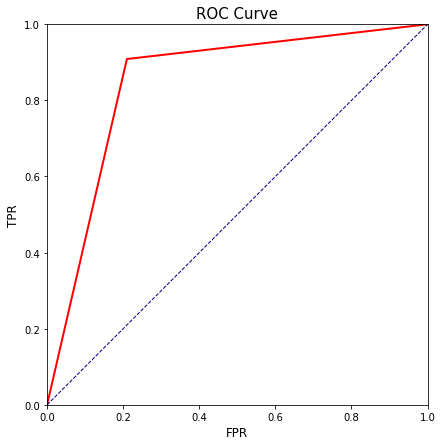

AUC Score: 0.8494772120784819


In [52]:
fig, ax = plt.subplots(figsize=(7,7))

fpr, tpr, _ = roc_curve(y_val, y_pred)
ax.plot(fpr, tpr, color='r', lw=2)
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.gca().set_aspect('equal')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("FPR", size=12)
ax.set_ylabel("TPR", size=12)
ax.set_title("ROC Curve", size=15)

plt.show()

print("AUC Score:", roc_auc_score(y_val, y_pred))

## Permutation Importance

In [53]:
result = permutation_importance(lgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

In [54]:
importance = pd.DataFrame({"Feature" : X_val.columns[sorted_idx], 
                           "Importance" : result.importances_mean[sorted_idx]})\
                        .sort_values("Importance", ascending=False).reset_index(drop=True)
importance.T

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
Feature,sensor_02_step_std,sensor_04_step_std,sensor_04_step_max,subject,sensor_10_step_std,sensor_04_step_min,sensor_04_step_mean,sensor_08_step_std,sensor_02_step_max,sensor_04_step_median,...,step,sensor_00,sensor_01,sensor_09,sensor_03_step_diff,sensor_03,sensor_04,sensor_05,sensor_06,sensor_05_step_diff
Importance,0.105661,0.053306,0.022146,0.019414,0.018464,0.018144,0.011302,0.010453,0.010325,0.009401,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


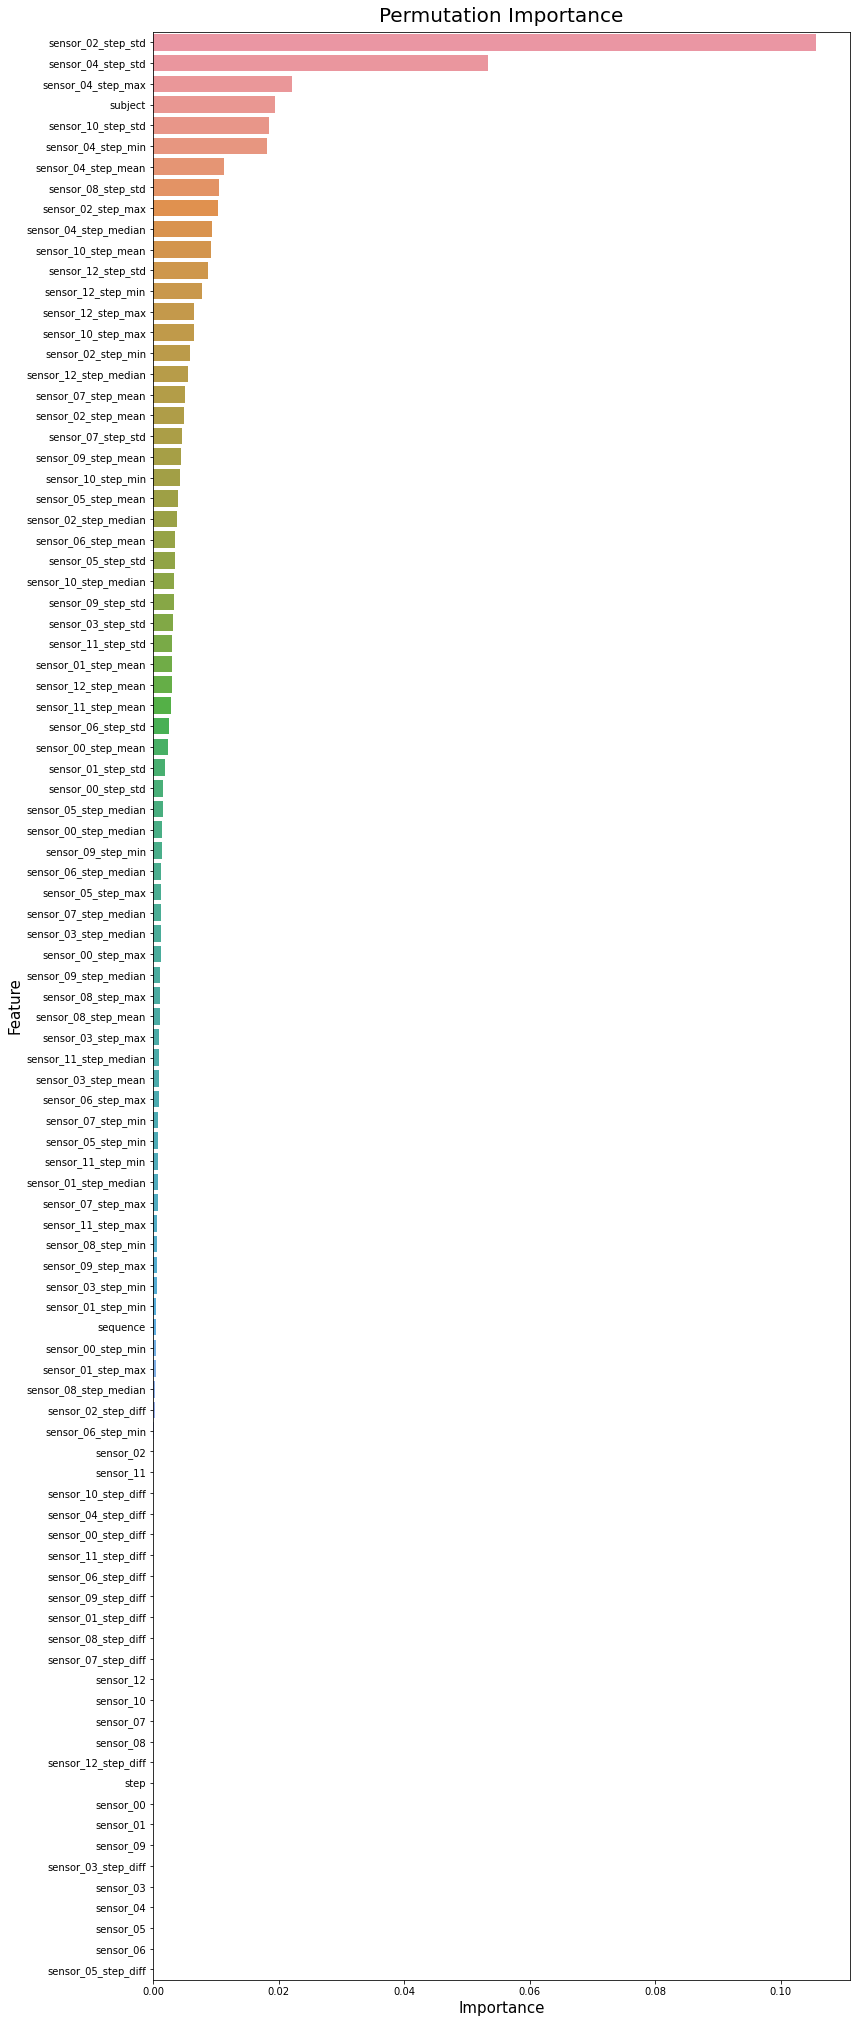

In [55]:
fig, ax = plt.subplots(figsize=(12,len(importance)*0.3))
sns.barplot(x = "Importance", y = "Feature", data=importance)
ax.set_title("Permutation Importance", pad = 10, size = 20)
# ax.set_xlim(-0.001, 0.13)
ax.set_xlabel("Importance", fontsize=15)
ax.set_ylabel("Feature", fontsize=15)
fig.tight_layout()
plt.show()

# Step 5. Submission

In [56]:
lgb_test= lgb.predict(test)
pred = pd.DataFrame({"sequence":test['sequence'],
                     "state":lgb_test.tolist()})
pred['state'].value_counts()

0    377396
1    355684
Name: state, dtype: int64

In [57]:
pred_fin = pred.groupby('sequence').mean().reset_index()
pred_fin['state'].value_counts()

0.000000    6019
1.000000    5916
0.016667     196
0.033333      71
0.050000       7
0.083333       3
0.983333       3
0.966667       2
0.950000       1
Name: state, dtype: int64

In [58]:
submission['state'] = pred_fin['state']
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12218 entries, 0 to 12217
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sequence  12218 non-null  int64  
 1   state     12218 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 191.0 KB


In [59]:
submission.to_csv('submission.csv', index=False)